# Model fitting

In [6]:
#!/usr/bin/python
# by DBR 2/2017 #

%matplotlib inline  

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pyDOE
from scipy.stats import pearsonr,spearmanr,norm,lognorm
from all_models import *

plt.style.use('seaborn-white')

#colors for plotting
cz=[ 'darkcyan','indigo','blue', 'royalblue',
    'indianred', 'darkred', 'salmon', 'red']

#upload data
prim_df = pd.DataFrame.from_csv('prim_df.csv')
prim_weeks = pd.DataFrame.from_csv('prim_weeks.csv')
ATI_df = pd.DataFrame.from_csv('ATI_df.csv')
ATI_weeks = pd.DataFrame.from_csv('ATI_weeks.csv')


/Applications/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:

#names of parameters to vary
param_names=[
            r'$\alpha_S$',
            r'$\delta_E$',
            r'$\omega$',
            r'$S_0$',
            r'$E_0$']


In [8]:
#initial conditions that are always true regardless of model
U0=0      #no infected cells
V0=0.03   #start with 30 copies per mL
P0=0      #productively infected cells

def run1(tt,*p):
    
    aS=p[0]
    dE=p[1]
    w=p[2]
    S0=p[3]
    E0=p[4]
    
    dS = 0.3;   #susceptible death rate [1/day] 
    Bt = 1e-4;  #infectivity [cells/virion-day]
    tau= 0.05   #productively infected probability
    dP = 1;     #productively infected death rate [1/day]
    dU = 1;     #unproductively infected death rate [1/day]
    k  = 10;  #immune cell killing rate [1/day]
    aE = 0.001;  #initial E cell concentration [cells/uL]
    E50 = 25;   #50 pct max E cell concentration [cells/uL]
    p  = 5e4    #leak+burst viral production rate [virions/cell]
    g  = 23     #viral clearance [1/day]

    sol=odeint(model_1, [S0,U0,P0,E0,V0], tt, 
           (aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g), mxstep=1000)
    
    logV=np.log10(sol[:,4]*1e3) #log viral load copies per mL

    return logV


In [9]:
#now the function that picks a bunch of initial conditions from lhs and
#THEN uses least squares to fit from there
def lhs_fit(guess,guess_bounds,sampz,t_data,V_data):
    
    #make the lhs samples
    lhs_samples = pyDOE.lhs( int(len(guess)), samples=sampz, criterion='center')

    #for each lhs_sample, do a fitting procedure with least-sq
    init_params=[]; fit_params=[]; covs=[]; loglik=[]; rms=[];

    for i in range(sampz):

        #LHS logarithmically covering
        lhs_list = 10**(np.log10(guess_bounds[0])+lhs_samples[i]*(np.log10(guess_bounds[1])
                                                                  -np.log10(guess_bounds[0])))
        p0=tuple(lhs_list)
        
        V_sim = run1(t_data,p0)

        if (V_sim<-6).any(): #don't simulate ranges that have logV<0 or V<1 per uL
            init_params.append(lhs_list)
            fit_params.append(lhs_list)
            covs.append(np.zeros([len(lhs_list),len(lhs_list)]))
            rms.append(100)
            loglik.append(-100)

        else:
            #bounds are +/- 1 log from lhs choice of initial conditions
            lhs_bounds = tuple([tuple(np.array(lhs_list)/10),tuple(np.array(lhs_list)*10)])

            #now use least squares to fit "run1" with all these lhs initial conditions
            p_opt, p_cov = curve_fit(run1, t_data, V_data, p0=p0)#, bounds=lhs_bounds,sigma=1)#, absolute_sigma=True, max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)#,loss='soft_l1')
                        
            V_sim = run1(t_data,tuple(p_opt))
            
            rms.append(np.sqrt(np.nanmean((V_data-V_sim)**2))) #rms error
            loglik.append(np.log10(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood

            #plt.plot(t_data,V_sim)

            init_params.append(lhs_list)
            fit_params.append(p_opt)
            covs.append(p_cov)
        
    return np.array(loglik),np.array(rms),np.array(init_params),np.array(fit_params),np.array(covs)



In [10]:
#try it for a single monkey!

aS = 100;   #constant growth rate of susceptibles [cells/uL/day]
dS = 0.3;   #susceptible death rate [1/day] 
Bt = 1e-4;  #infectivity [cells/virion-day]
tau= 0.05   #productively infected probability
dP = 1;     #productively infected death rate [1/day]
dU = 1;     #unproductively infected death rate [1/day]
k  = 10;  #immune cell killing rate [1/day]
aE = 0.001;  #initial E cell concentration [cells/uL]
dE = 0.1; #immune death rate [1/day]
E50 = 25;   #50 pct max E cell concentration [cells/uL]
w  = 0.01;  #immune cell multiplier [1/day]
p  = 5e4    #leak+burst viral production rate [virions/cell]
g  = 23     #viral clearance [1/day]
S0 = aS/dS
E0 = aE/dE

guess = aS,dE,w,S0,E0

guess_bounds = tuple([tuple(np.array(guess)/100),tuple(np.array(guess)*100)])

#choose which monkeys to fit
for m in [1]:

    t_data = prim_weeks.values[:,0]*7 #put in days scale
    V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data

    sampz=5

    #make the lhs samples
    lhs_samples = pyDOE.lhs( int(len(guess)), samples=sampz, criterion='center')

    loglik,rms,init_params,fit_params,covs=lhs_fit(guess,guess_bounds,sampz,t_data,V_data)

    ranked_sets = (-loglik).argsort()

    tt=np.linspace(0,35*7,1e3) #extrapolate a bit beyond data

    num_fits=3 #how many lhs samples to show, must be >1 and <sampz 
    fig,axarr = plt.subplots(num_fits,3,figsize=(10,6),dpi=600)
    for i in range(num_fits):

        fitprmz=fit_params[ranked_sets[i]]
        
        aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0=tuple(fitprmz)
        
        V_sim = run1(tt,aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0)

        mean_sq = np.transpose(np.matrix(fitprmz))*np.matrix(fitprmz)#matrix of param values to normalize

        print(fitprmz)
        
        ax1=axarr[i][0]
        ax1.plot(t_data/7,V_data,'o')
        ax1.plot(tt/7,V_sim)
        ax1.set_title((round(loglik[ranked_sets[i]],3),round(rms[ranked_sets[i]],3)),fontsize=8)
        ax1.set_ylabel('viral load \n log10(copies/mL)', fontsize=10)

        #try to figure out how to visualize the search
        ax2=axarr[i][1]
        ax2.scatter(range(len(guess)),(init_params[ranked_sets[i]]-guess)/guess,marker='o',alpha=0.2)
        ax2.scatter(range(len(guess)),(fitprmz-guess)/guess,marker='*',alpha=0.8)   
        ax2.set_xticks(range(len(param_names)))
        ax2.set_xticklabels(param_names)
        ax2.set_ylabel('deviation \n from guess', fontsize=10)

        ax3=axarr[i][2]
        f=ax3.matshow(np.log10(np.abs(covs[ranked_sets[i]])/mean_sq))
        #f=ax3.matshow(np.sqrt(covs[ranked_sets[i]])/mean_sq)
        f.set_clim([0,7])
        ax3.set_xticks(range(len(param_names)))
        ax3.set_xticklabels(param_names,fontsize=6)
        ax3.set_yticks(range(len(param_names)))
        ax3.set_yticklabels(param_names,fontsize=6)
        #cbar = fig.colorbar(ax3)

    axarr[i][0].set_xlabel('time (weeks)')
    axarr[i][1].legend(['pre-fit (LHS)','post-fit'],fontsize=8,loc=2)
    axarr[i][1].set_xlabel('parameter')
    axarr[1][2].set_ylabel('covariances')
    plt.tight_layout()

    plt.savefig('model_1_fit'+str(m)+'.pdf')

IndexError: tuple index out of range

In [11]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, *p): 
    return p[0] + p[1] * x

popt, pcov = curve_fit(func, np.arange(10), np.arange(10), p0=(0, 0))
print popt,pcov

[  1.06758518e-24   1.00000000e+00] [[  1.90435953e-30  -0.00000000e+00]
 [  0.00000000e+00   6.68196326e-33]]


In [12]:
run1(tt,*p)

NameError: name 'tt' is not defined

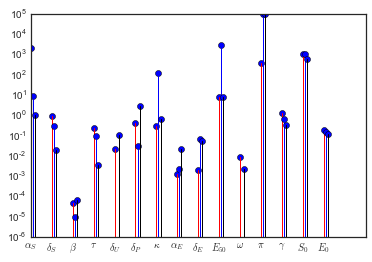

In [30]:

#high setpoint

hi = [  2.06043062e+03,   8.69081027e-01,   4.61813404e-05,   2.37331327e-01,
   2.08470988e-02,   3.96335391e-01,   2.77097245e-01,   1.28768454e-03,
   1.96415904e-03,   7.52873533e+00,   8.38958971e-03,   3.48904435e+02,
   1.29247137e+00,   9.70295513e+02,   1.91001457e-01,]

#low setpoint

lo = [  8.83736329e+00,   3.02943983e-01,   9.13995397e-06,   9.32495180e-02,
  -8.26756582e-01,   3.09726362e-02,   1.18387021e+02,   2.18658290e-03,
   6.67194188e-02,   2.94213594e+03,  -2.98352978e-03,   9.63528063e+04,
   6.21235157e-01,   1.07818261e+03,   1.38171046e-01,]

med = [  9.54333884e-01,   1.97060611e-02,   6.52559837e-05,   3.57172022e-03,
   1.09353707e-01,   2.74784033e+00,   6.15659153e-01,   2.18539027e-02,
   5.47983413e-02,   7.88798960e+00,   2.27103039e-03,   9.93382051e+04,
   3.15320753e-01,   6.11316278e+02,   1.10467478e-01,]

x=np.arange(len(hi))
plt.stem(x,hi,'r')
plt.stem(x+0.1,lo)
plt.stem(x+0.2,med,'k')
plt.xticks(x,param_names)
plt.yscale('log')